**COVID Vaccination Prediction**

**Dataset** : https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/vaccinations.csv

---

In this project, I will be implementing a Neural Network architecture to perform Regression on this dataset.

The steps would be:
1. Preprocessing and feature engineering
2. Feature selection
3. Feature Standardization (Generalization/Normalization)
4. Hyperparameter tuning
5. Training and then testing


---

>Mathieu, E., Ritchie, H., Ortiz-Ospina, E. et al. A global database of COVID-19 vaccinations. Nat Hum Behav (2021). https://doi.org/10.1038/s41562-021-01122-8

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, max_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [ ]:
dt = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")

In [ ]:
dt.tail()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
19437,Zimbabwe,ZWE,2021-05-10,690653.0,529360.0,161293.0,6410.0,21877.0,4.65,3.56,1.09,1472.0
19438,Zimbabwe,ZWE,2021-05-11,709772.0,539526.0,170246.0,19119.0,21428.0,4.78,3.63,1.15,1442.0
19439,Zimbabwe,ZWE,2021-05-12,730365.0,549797.0,180568.0,20593.0,22019.0,4.91,3.70,1.21,1481.0
19440,Zimbabwe,ZWE,2021-05-13,752020.0,559875.0,192145.0,21655.0,20666.0,5.06,3.77,1.29,1390.0
19441,Zimbabwe,ZWE,2021-05-14,775241.0,571460.0,203781.0,23221.0,19211.0,5.22,3.84,1.37,1293.0


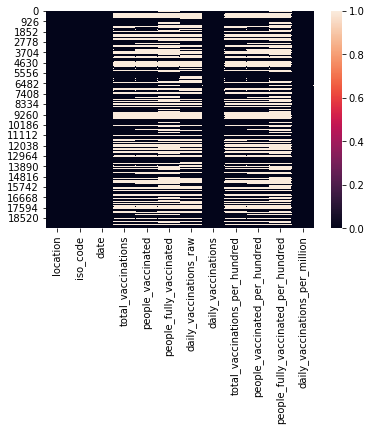

In [ ]:
sns.heatmap(dt.isnull())

In [ ]:
dt = dt.drop(['daily_vaccinations','people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations_raw', 
         'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 
         'daily_vaccinations_per_million'], axis = 1)

location              0
iso_code              0
date                  0
total_vaccinations    0
dtype: int64

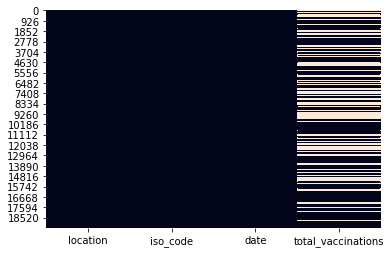

In [ ]:
sns.heatmap(dt.isnull(), cbar = False)
dt = dt.dropna()
dt = dt[dt.total_vaccinations != 0]
dt.isna().sum()

**Let's take a look at the dates.**

---

As it can be seen, if the model is trained on this data, it will give higher significance to December of 2020 if we separate the date into month, year, and day.

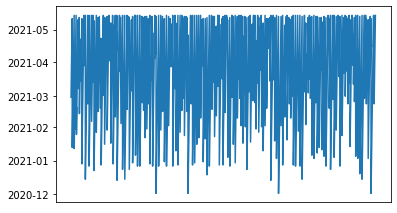

In [ ]:
lens = dt.shape[0]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(pd.to_datetime(dt['date']).astype('datetime64'))
plt.gcf().autofmt_xdate()

In [ ]:
dt[["year", "month", "day"]] = pd.to_datetime(dt["date"]).dt.strftime('%Y-%m-%d').str.split('-', expand = True).astype('int64')

In [ ]:
dt

,location,iso_code,date,total_vaccinations,year,month,day
6,Afghanistan,AFG,2021-02-28,8200.0,2021,2,28
22,Afghanistan,AFG,2021-03-16,54000.0,2021,3,16
44,Afghanistan,AFG,2021-04-07,120000.0,2021,4,7
59,Afghanistan,AFG,2021-04-22,240000.0,2021,4,22
78,Afghanistan,AFG,2021-05-11,504502.0,2021,5,11
...,...,...,...,...,...,...,...
19437,Zimbabwe,ZWE,2021-05-10,690653.0,2021,5,10
19438,Zimbabwe,ZWE,2021-05-11,709772.0,2021,5,11
19439,Zimbabwe,ZWE,2021-05-12,730365.0,2021,5,12
19440,Zimbabwe,ZWE,2021-05-13,752020.0,2021,5,13


**Using normalized date here causes certain problems regarding input, hence it is standardized.**

In [ ]:
col = ['total_vaccinations', 'year', 'month', 'day']
mean = {}
stdev = {}
for i in col:
  mean[i] = dt.mean(axis = 0)[i]
  stdev[i] = dt.std(axis = 0)[i]
  std = StandardScaler().fit(dt[[i]])
  dt[i] = std.transform(dt[[i]])
dt

,location,iso_code,date,total_vaccinations,year,month,day
6,Afghanistan,AFG,2021-02-28,-0.245988,0.168855,-0.730738,1.457823
22,Afghanistan,AFG,2021-03-16,-0.245468,0.168855,-0.203027,0.089363
44,Afghanistan,AFG,2021-04-07,-0.244719,0.168855,0.324683,-0.936982
59,Afghanistan,AFG,2021-04-22,-0.243357,0.168855,0.324683,0.773593
78,Afghanistan,AFG,2021-05-11,-0.240354,0.168855,0.852394,-0.480829
...,...,...,...,...,...,...,...
19437,Zimbabwe,ZWE,2021-05-10,-0.238240,0.168855,0.852394,-0.594867
19438,Zimbabwe,ZWE,2021-05-11,-0.238023,0.168855,0.852394,-0.480829
19439,Zimbabwe,ZWE,2021-05-12,-0.237789,0.168855,0.852394,-0.366791
19440,Zimbabwe,ZWE,2021-05-13,-0.237544,0.168855,0.852394,-0.252752


In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['location'])], axis = 1)
dt = dt.drop('location', axis = 1)

In [ ]:
dt = dt.drop('iso_code', axis = 1)

In [ ]:
dt = dt.drop('date', axis = 1)

In [ ]:
y = dt['total_vaccinations']
x = dt.drop('total_vaccinations', axis = 1)

In [ ]:
print(x)
print(y)

           year     month       day  ...  Yemen  Zambia  Zimbabwe
6      0.168855 -0.730738  1.457823  ...      0       0         0
22     0.168855 -0.203027  0.089363  ...      0       0         0
44     0.168855  0.324683 -0.936982  ...      0       0         0
59     0.168855  0.324683  0.773593  ...      0       0         0
78     0.168855  0.852394 -0.480829  ...      0       0         0
...         ...       ...       ...  ...    ...     ...       ...
19437  0.168855  0.852394 -0.594867  ...      0       0         1
19438  0.168855  0.852394 -0.480829  ...      0       0         1
19439  0.168855  0.852394 -0.366791  ...      0       0         1
19440  0.168855  0.852394 -0.252752  ...      0       0         1
19441  0.168855  0.852394 -0.138714  ...      0       0         1

[11868 rows x 226 columns]
6       -0.245988
22      -0.245468
44      -0.244719
59      -0.243357
78      -0.240354
           ...   
19437   -0.238240
19438   -0.238023
19439   -0.237789
19440   -0.237544


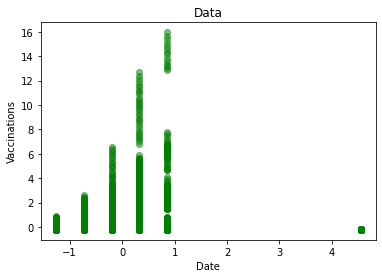

In [ ]:
plt.scatter(x["month"], y, color = "green", alpha = 0.5)
plt.title("Data")
plt.xlabel("Date")
plt.ylabel("Vaccinations")
plt.show()

**Observations**


---
|Hidden layer sizes|Learning rate|Solver|Learning rate initialization|Training score|Test score|MSE|
|------------------|-------------|------|----------------------------|--------------|----------|---|
|(100,)|Adaptive|Adam|0.05|99.87%|99.56%|~0.002|
|(400,)|Adaptive|Adam|0.05|99.06%|98.92%|~0.0001|
|(50, 50, 10)|Adaptive|Adam|0.05|99.54%|99.65%|~0.0035|
|(200,)|Adaptive|Adam|0.025|96.3%|94.1%|~0.00055|






**Grid Search CV with KFold Cross Validation**
This approach took almost 29 minutes with the grid parameters given below.
It gave approx. 99.92% score on training data and 99.9% on test data with approx. 0.009 MSE


---


The best parameters are 


1.   Hidden Layers : (100, 50)
2.   Learning rate : Adaptive
3.   Learning rate initialization : 0.05
4.   Solver : SGD



In [ ]:
print(f"Total features: {x.shape[1]}")
print(f"Total samples: {x.shape[0]}")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
grid_params = {
    "learning_rate" : ["adaptive", "constant"],
    "hidden_layer_sizes" : [(100,), (50, 50, 10,), (50,), (100, 50,), (50, 10,)],
    "solver" : ["sgd", "adam"],
    "learning_rate_init" : [0.05, 0.025, 0.001]
}
regr = MLPRegressor()
cv = KFold(n_splits = 5, shuffle = False, random_state = None)
bestregr = GridSearchCV(regr, param_grid = grid_params, return_train_score = True, cv = cv)
bestregr.fit(x_train, y_train).score(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9992675659954152

In [ ]:
print(f"The score of the best estimator is {bestregr.best_score_}")
print(f"The best params are {bestregr.best_params_}")

The score of the best estimator is 0.9984412993728601
The best params are {'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.05, 'solver': 'sgd'}


0.9988950259429054
On the training set, 
Mean squared error: 0.0007309673485575771
Max error: 0.3520473066963614
On the test set, 
Mean squared error: 0.0011100867090779612
Max error: 0.5400498270354075


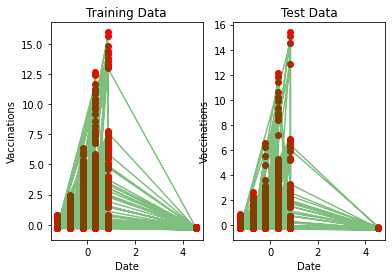

In [ ]:
print(bestregr.score(x_test, y_test))
prediction_train = bestregr.predict(x_train)
prediction_test = bestregr.predict(x_test)
print("On the training set, ")
print(f"Mean squared error: {mean_squared_error(y_train, prediction_train)}")
print(f"Max error: {max_error(y_train, prediction_train)}")
print("On the test set, ")
print(f"Mean squared error: {mean_squared_error(y_test, prediction_test)}")
print(f"Max error: {max_error(y_test, prediction_test)}")

plt.subplot(1, 2, 1)
plt.scatter(x_train["month"], y_train, color = "red")
plt.plot(x_train["month"], prediction_train, color = "green", alpha = 0.5)
plt.title("Training Data")
plt.xlabel("Date")
plt.ylabel("Vaccinations")

plt.subplot(1, 2, 2)
plt.scatter(x_test["month"], y_test, color = "red")
plt.plot(x_test["month"], prediction_test, color = "green", alpha = 0.5)
plt.title("Test Data")
plt.xlabel("Date")
plt.ylabel("Vaccinations")
plt.show()